In [1]:
import utils
from pathlib import Path
import pandas as pd

# Loading and Cleaning

In [2]:
%%time

df = utils.load_transactions(Path("../data/jointexpenses/"))
df = utils.clean(df)
print(df.shape)
df = utils.deduplicate_transactions(df)
print(df.shape)
df = utils.classify_transactions(df)

other_transactions = df[df.classification == "Other"]
ground_truth_transactions = df[df.classification != "Other"]

X = ground_truth_transactions.desc
y = ground_truth_transactions.classification
print(X.shape)
X_other = other_transactions.desc
# y_other = ground_truth_transactions.classification

(1706, 5)
Found 507 duplicated entries 
and 0 duplicates on the same day from the same file.
(765, 5)
(730,)
CPU times: user 79.5 ms, sys: 8.06 ms, total: 87.5 ms
Wall time: 92.4 ms


# Vectorise Word Embeddings

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer

In [4]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, X_test.shape)
# vect_config = {"ngram_range": (1,6)}
# Vectorizer = HashingVectorizer

vect_config = {}
Vectorizer = CountVectorizer

vect = Vectorizer(**vect_config)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
X_other_dtm = vect.transform(X_other)
# print(vect.vocabulary_)

(547,) (183,)
CPU times: user 9.7 ms, sys: 1.45 ms, total: 11.1 ms
Wall time: 10.2 ms


# Experiments

In [5]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [14, 12]
plt.rcParams["figure.dpi"] = 100  # 200 e.g. is really fine, but slower

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay

In [6]:
experiments = [
    {"model": MultinomialNB, "config": {}},
    {"model": LogisticRegression, "config": {"class_weight": "balanced"}},
    {"model": LinearSVC, "config": {"class_weight": "balanced"}},
]

In [7]:
%%time

predictions = {}
other_predictions = {}

for experiment in experiments:
    Model = experiment["model"]
    config = experiment["config"]
    model = Model(**config)
    model.fit(X_train_dtm, y_train)
    predictions[Model.__name__] = model.predict(X_test_dtm)
    other_predictions[Model.__name__] = model.predict(X_other_dtm)

CPU times: user 106 ms, sys: 3.31 ms, total: 110 ms
Wall time: 109 ms


# Results and Model Evaluation



=====MultinomialNB=====
Accuracy:  0.9234972677595629
(Precision, Recall, F1-score, support): (0.9250142728978061, 0.9234972677595629, 0.9210602564810216, None)


/Users/jpeak/play/nlp-classify-bank-transactions/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


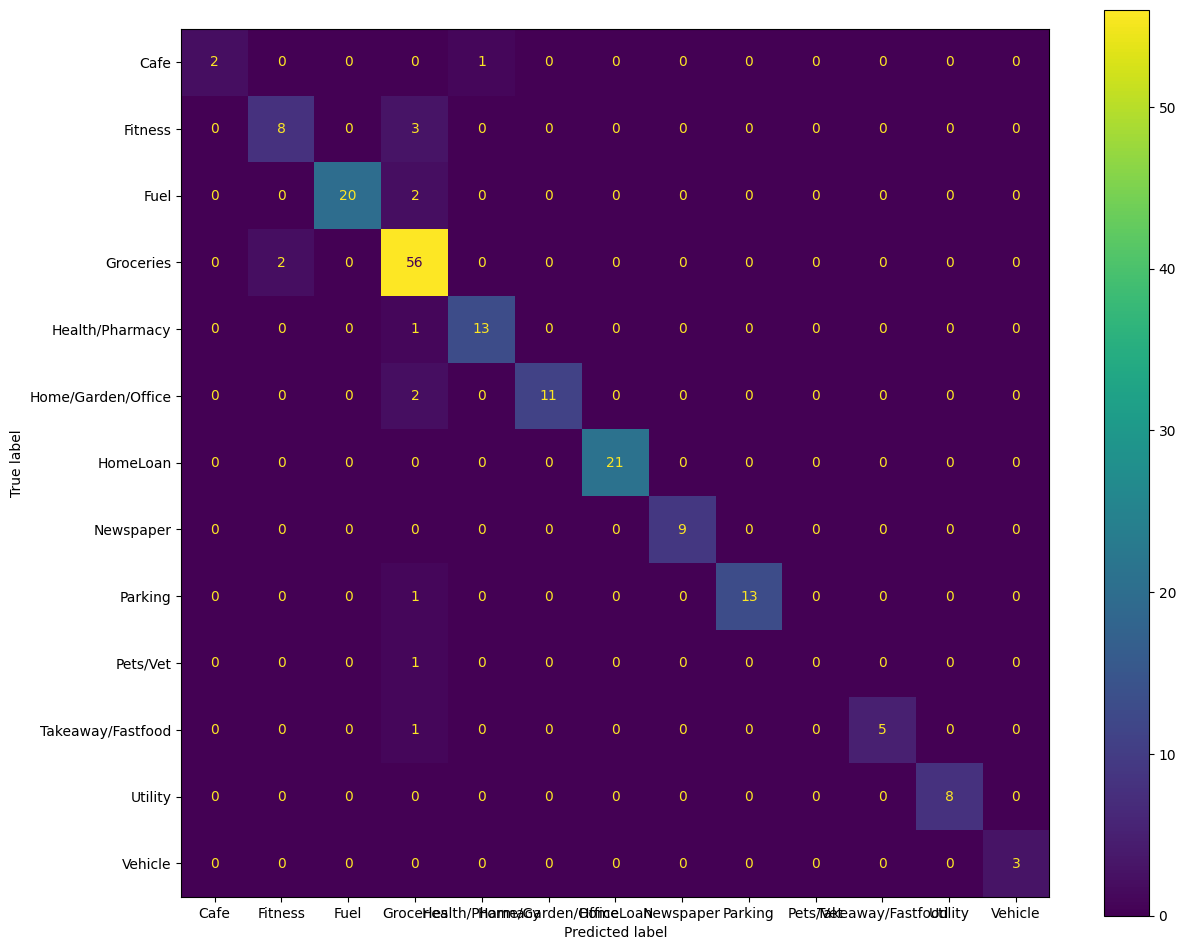

-----Misclassifications-----
                                    desc      classification       prediction
71                      URBANBASEFITNESS             Fitness        Groceries
671         Wallsend Veterinary Wallsend            Pets/Vet        Groceries
531  PLINE PH KURRI KURRI KURRI KURRIWAU     Health/Pharmacy        Groceries
23                      URBANBASEFITNESS             Fitness        Groceries
744                        TARGET KOTARA  Home/Garden/Office        Groceries
60        METRO PETROLEUM BALLIN BALLINA                Fuel        Groceries
61                   CAPE CAFE BYRON BAY                Cafe  Health/Pharmacy
734    THE ESSENTIAL INGRED THE JUNCTION           Groceries          Fitness
652              WESTFIELD KOTARA KOTARA             Parking        Groceries
106                     URBANBASEFITNESS             Fitness        Groceries
664       MCDONALDS WALLSEND WALLSENDWAU   Takeaway/Fastfood        Groceries
86     THE ESSENTIAL INGRED THE JUN

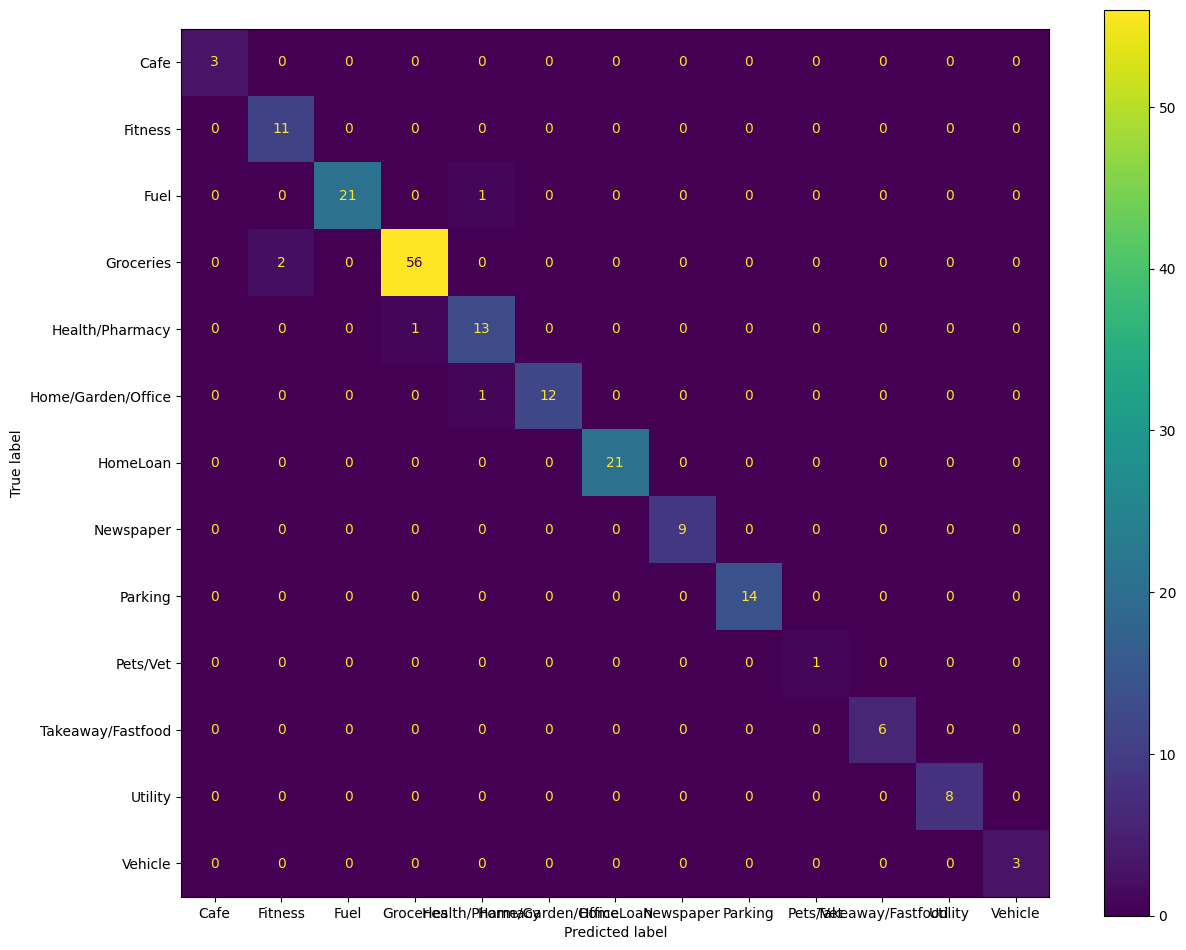

-----Misclassifications-----
                                    desc      classification       prediction
161                   TARGET CHARLESTOWN  Home/Garden/Office  Health/Pharmacy
531  PLINE PH KURRI KURRI KURRI KURRIWAU     Health/Pharmacy        Groceries
60        METRO PETROLEUM BALLIN BALLINA                Fuel  Health/Pharmacy
734    THE ESSENTIAL INGRED THE JUNCTION           Groceries          Fitness
86     THE ESSENTIAL INGRED THE JUNCTION           Groceries          Fitness


=====LinearSVC=====
Accuracy:  0.9781420765027322
(Precision, Recall, F1-score, support): (0.9805555555555555, 0.9781420765027322, 0.9788054805793323, None)


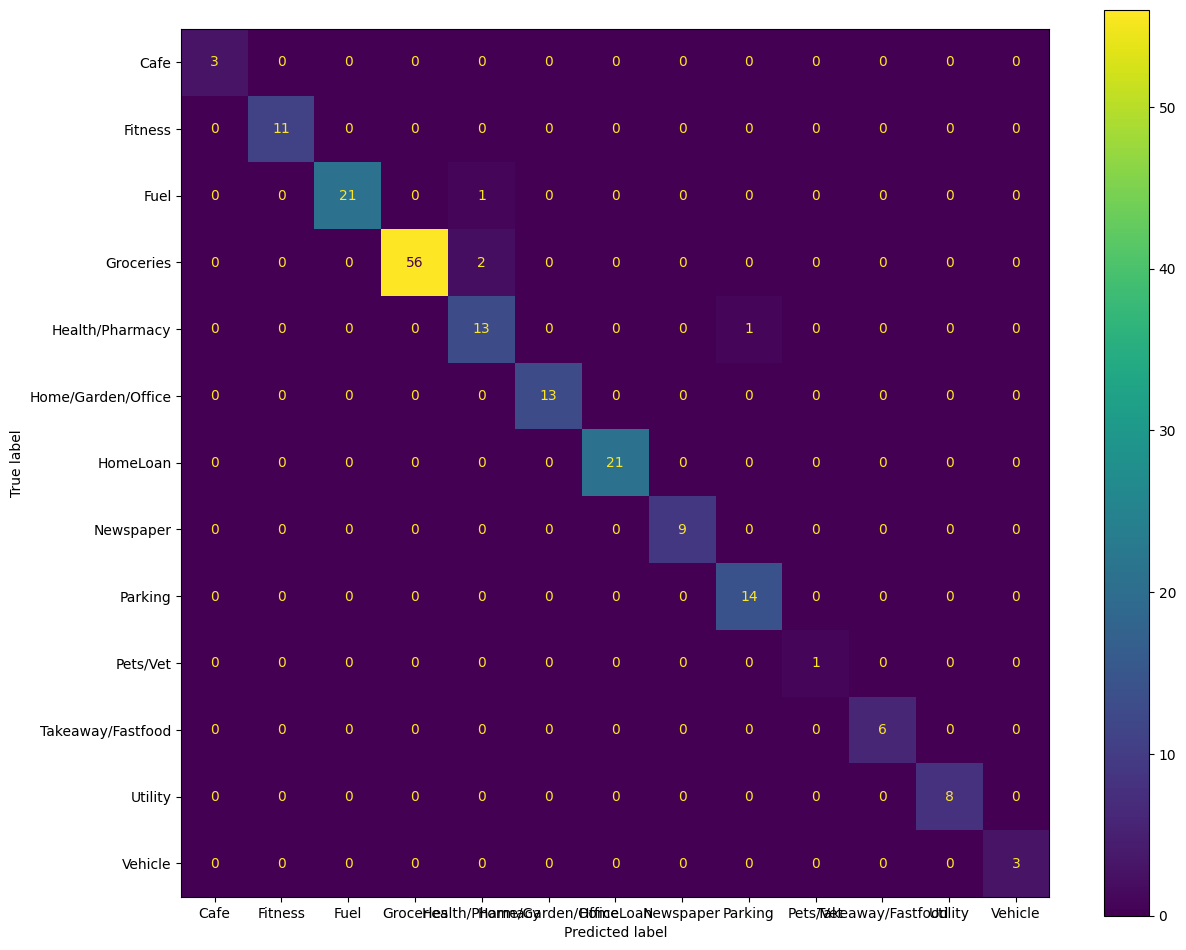

-----Misclassifications-----
                                    desc   classification       prediction
531  PLINE PH KURRI KURRI KURRI KURRIWAU  Health/Pharmacy          Parking
60        METRO PETROLEUM BALLIN BALLINA             Fuel  Health/Pharmacy
734    THE ESSENTIAL INGRED THE JUNCTION        Groceries  Health/Pharmacy
86     THE ESSENTIAL INGRED THE JUNCTION        Groceries  Health/Pharmacy


In [8]:
for model_name, y_pred_class in predictions.items():
    print(f"\n\n====={model_name}=====")
    print("Accuracy: ", accuracy_score(y_test, y_pred_class))
    print(
        f"(Precision, Recall, F1-score, support): {precision_recall_fscore_support(y_test, y_pred_class, average='weighted')}"
    )

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_class)
    plt.show()

    print("-----Misclassifications-----")
    df = pd.concat([X_test, y_test], axis=1)
    df.loc[:, "prediction"] = y_pred_class
    print(df[df.classification != df.prediction])

In [9]:
# for model_name, y_pred_class in other_predictions.items():
#     print(f"====={model_name}=====")
#     print(len(y_pred_class))
#     print(other_transactions.shape)
#     other_transactions.loc[:, "classification"] = y_pred_class
#     print(other_transactions[["desc", "classification"]])